## <u>*Regression Modelling for claims cost as a Target Feature*</u>

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import (
    root_mean_squared_error,r2_score
)

from sklearn.ensemble import (
    RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
)

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBRFRegressor

from sklearn.linear_model import (
    LinearRegression,GammaRegressor,ElasticNet
)

from sklearn.model_selection import (
    train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
)

from sklearn.preprocessing import (
        LabelEncoder,StandardScaler,PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
        )

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from hyperopt import (
    fmin, tpe, hp, SparkTrials, STATUS_OK,Trials
)

In [32]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


In [33]:
df.shape

(67856, 8)

---

In [34]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


In [35]:
df.groupby("gender")["claimcst0"].mean().to_frame().T

gender,F,M
claimcst0,127.159782,150.612087


In [36]:
df.groupby("agecat")["claimcst0"].mean().to_frame().T

agecat,1,2,3,4,5,6
claimcst0,227.68598,154.162388,135.22592,132.516093,98.864771,104.409426


In [37]:
df.groupby("veh_age")["claimcst0"].mean().to_frame().T

veh_age,1,2,3,4
claimcst0,126.887077,149.889496,135.478319,134.837211


In [38]:
df.groupby("veh_body")["claimcst0"].mean().to_frame().T

veh_body,BUS,CONVT,COUPE,HBACK,HDTOP,MCARA,MIBUS,PANVN,RDSTR,SEDAN,STNWG,TRUCK,UTE
claimcst0,278.398333,85.047037,240.670834,136.882696,186.70796,84.04685,161.931492,177.012517,50.720673,120.614513,145.322625,182.569628,130.224371


In [39]:
df.groupby("area")["claimcst0"].mean().to_frame().T

area,A,B,C,D,E,F
claimcst0,127.008681,134.56976,139.518365,111.471694,146.959224,224.135098


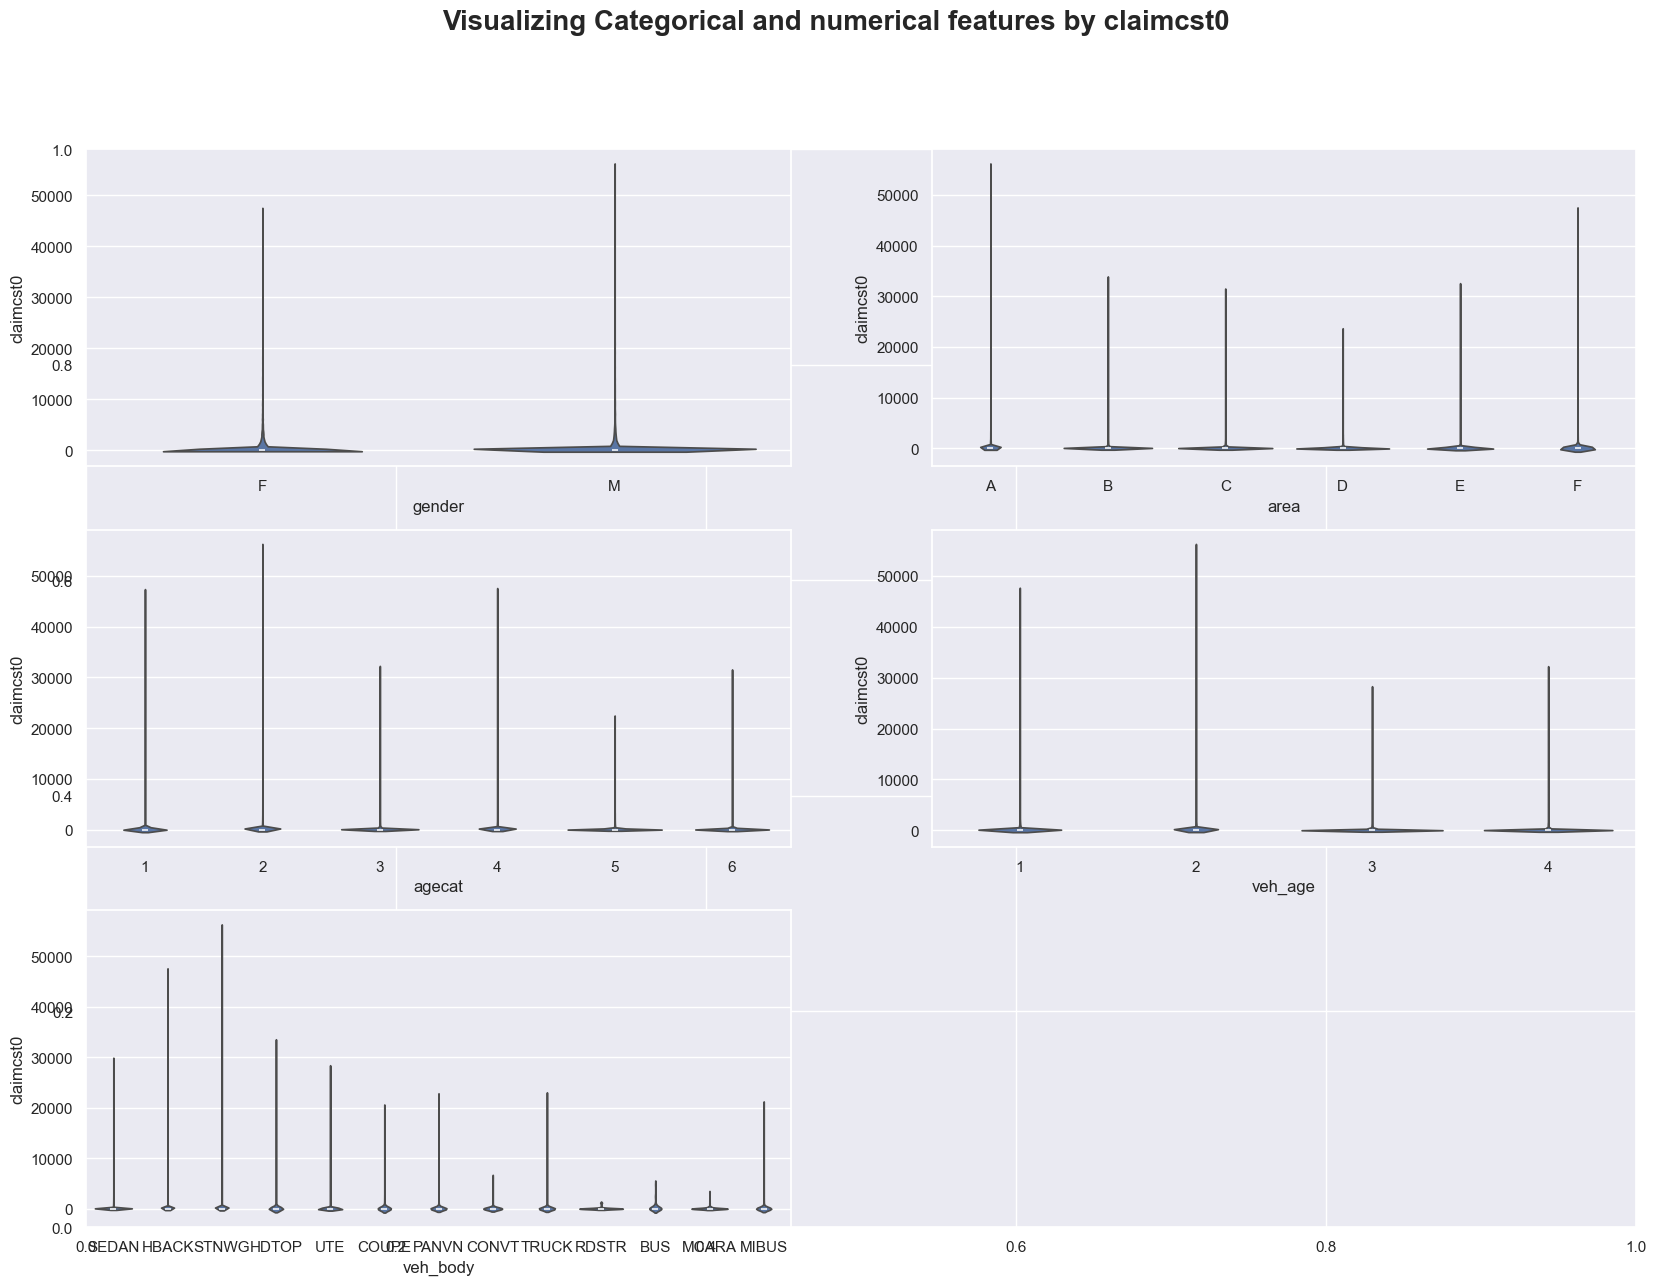

In [40]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by claimcst0",fontsize=20,fontweight="bold")
plt.subplot(321)
sns.violinplot(x="gender",y="claimcst0",data=df)
plt.subplot(322)
sns.violinplot(x="area",y="claimcst0",data=df)
plt.subplot(323)
sns.violinplot(x="agecat",y="claimcst0",data=df)
plt.subplot(324)
sns.violinplot(x="veh_age",y="claimcst0",data=df)
plt.subplot(325)
sns.violinplot(x="veh_body",y="claimcst0",data=df)

plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_claimcst0.png',dpi=500);

---

In [41]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [43]:
x=df.drop("claimcst0",axis=1)
y=df["claimcst0"]

In [44]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value']
df[transform_features]=pt.fit_transform(x[transform_features])

In [45]:
sc=StandardScaler()
preprocessor=ColumnTransformer([
    ("StandardScaler",sc,x.columns)
]
)

In [46]:
x=preprocessor.fit_transform(x)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (54284, 7) and Y = (54284,) : 
Test data shape of X = (13572, 7) and Y = (13572,) : 


---

*Define models :*

In [54]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor(),
                "KNeighborsRegressor":KNeighborsRegressor()              
}

*Create cross validation evaluation_fucntion*

In [55]:
def evaluation_preds_list(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    r2score=r2_score(y_true,predicted)
    metrics_dict={
       "RMSE": round(RMSE,3),
       "r2score": round(r2score,3)
    }
   
    return metrics_dict

In [56]:
def evaluation_preds(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    return RMSE

In [57]:
def evalua_models(x_train,y_train,models):
    #x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    RMSE_list=[]
    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_RMSE=evaluation_preds(y_test,test_predicted)
       
        RMSE_list.append(test_predicted_RMSE)

        print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        print( test_predicted_RMSE)
        print("===========================")

    report=pd.DataFrame(list(zip(models_list,RMSE_list)),columns=["model","RMSE"]).sort_values(by="RMSE",ascending=True) 
    return report
  

In [58]:
evalua_models(x_train,y_train,models)

RandomForestRegressor
1136.3803114773434
DecisionTreeRegressor
1537.9635858177116
XGBRFRegressor
1080.3053587265895
GradientBoostingRegressor
1076.708671499445
AdaBoostRegressor
6625.737616454179
KNeighborsRegressor
1167.0756089622955


,model,RMSE
3,GradientBoostingRegressor,1076.708671
2,XGBRFRegressor,1080.305359
0,RandomForestRegressor,1136.380311
5,KNeighborsRegressor,1167.075609
1,DecisionTreeRegressor,1537.963586
4,AdaBoostRegressor,6625.737616


In [59]:
np.random.seed(42)
clf=GradientBoostingRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

In [60]:
clf.feature_names=list(df.drop("claimcst0",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.588330
1,exposure,0.183289
2,veh_body,0.009159
3,veh_age,0.029849
4,gender,0.011275
5,area,0.136554
6,agecat,0.041543


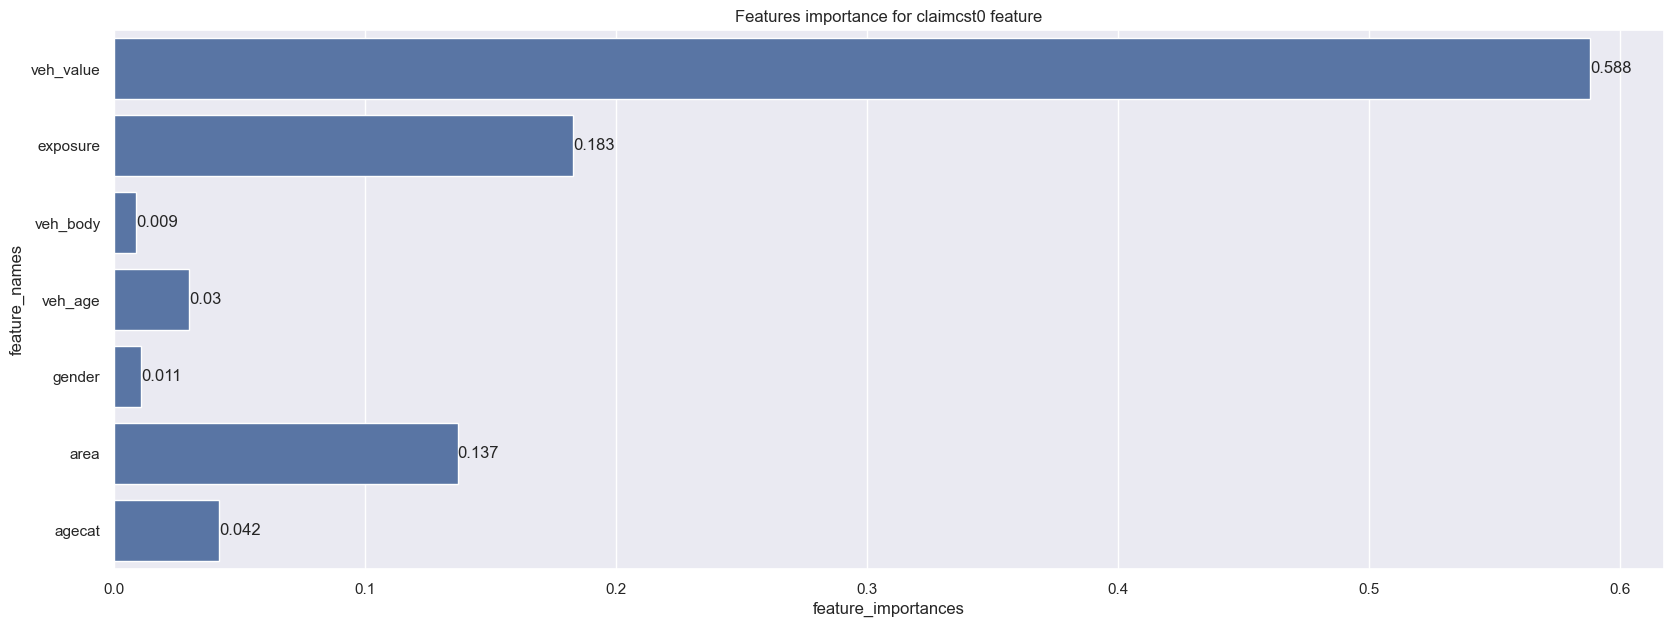

In [61]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for claimcst0 feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/claimcst0_featureImportanc.png',dpi=500);

In [62]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/claimcst0_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---